# Introduction

This project focuses on __Paratope Prediction__ (identifying the specific residues on an antibody that bind to an antigen). This touches on sequence (input), structure (training labels), and interaction (the physical binding).

__Objective:__ Build a model that takes an antibody amino acid sequence as input and predicts which specific residues will interact with a target antigen.

__Why this matters:__ Identifying paratopes is the first step in designing therapeutic antibodies (like drugs for cancer or viruses) without needing expensive wet-lab crystallography for every candidate.

In [1]:
#!pip install biopython
import Bio.PDB

# Bio.PDB doesn't automatically load the three_to_one helper anymore.
# We can fix this by explicitly importing the Polypeptide module and using its built-in dictionary (protein_letters_3to1) instead of the function.
from Bio.PDB import Polypeptide

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress bar
import requests
import os
import io
import warnings
import copy

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from huggingface_hub import notebook_login

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_recall_curve, auc, f1_score

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [3]:
notebook_login()

# 1. Download the PDB file automatically and Processing

I will use __[SAbDab](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab) (Structural Antibody Database)__. It is the gold standard for antibody-antigen complex data.

__Data Processing Goal:__ You need to create a "labeled" dataset where:
- __Input ($X$):__ The amino acid sequence of the antibody (Heavy and Light chains).
- __Target ($Y$):__ A binary label for each residue (0 = non-binding, 1 = binding).
> Definition of Binding: A residue is "binding" if any of its atoms are within 4.5 Å of any atom on the antigen. You calculate this using the PDB coordinates.

In here, we are not using Bio.PDB.PDBList().retrieve_pdb_file() to download the PDB file because the Biopython downloader (PDBList) tries to use FTP, which is often blocked by firewalls or network settings. It can also be flaky with case sensitivity.

We can bypass PDBList entirely and download the file directly from the RCSB PDB website using Python's standard requests library. It is much more reliable.

After downloading, we will extract sequences to get the amino acid string for the Heavy (H) and Light (L) chains.

For example, __"3HFM"__ is a unique ID (Accession Code) for a specific entry in the __Protein Data Bank (PDB)__, which is the global repository for 3D biological structures.

- __The Structure:__ It is a 3D snapshot of an immune system battle. It shows a mouse antibody (specifically named "HyHEL-10") physically grabbing onto an antigen (Hen Egg White Lysozyme).

- __Why we use it:__ It is a classic, high-quality dataset.

> __Chains H & L:__ These are the Antibody (Heavy and Light chains). We want to predict which parts of these chains are doing the grabbing.

> __Chain Y:__ This is the __Antigen__ (the target). This acts as the "ground truth" to check if our antibody is touching it.

## 1.1 DATA DISCOVERY (The SAbDab Source: Human Only)

Tries to download the live __SAbDab summary__. This is a live spreadsheet maintained by Oxford that lists every antibody structure ever solved.

In [4]:
url = "https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/summary/all/"
print(f"Attempting to fetch SAbDab summary from: {url}")

Attempting to fetch SAbDab summary from: https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/sabdab/summary/all/


In [5]:
# Verify the request first
response = requests.get(url, timeout=10)
response.raise_for_status()

# Parse the tab-separated file
# We use io.StringIO because the response is a text string
df = pd.read_csv(io.StringIO(response.text), sep="\t")

In [6]:
df

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,9rxi,H,NaN,0,B,protein,NaN,cathepsin d (a01 family),HYDROLASE,01/28/26,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9rxi,E,NaN,0,NaN,NaN,NaN,NaN,HYDROLASE,01/28/26,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9con,E,NaN,0,C,protein,NaN,potassium voltage-gated channel subfamily a me...,IMMUNE SYSTEM,01/28/26,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9con,F,NaN,0,B,protein,NaN,potassium voltage-gated channel subfamily a me...,IMMUNE SYSTEM,01/28/26,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9con,G,NaN,0,D,protein,NaN,potassium voltage-gated channel subfamily a me...,IMMUNE SYSTEM,01/28/26,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20504,6ejm,H,h,0,B,protein,NaN,cd81 antigen,CELL ADHESION,09/22/17,...,True,True,unknown,unknown,unknown,8.600000e-10,-12.367557,SPR,NaN,TBD
20505,7lo6,J,I,0,C,protein,NaN,envelope glycoprotein bg505 sosip.664 gp120,VIRAL PROTEIN/IMMUNE SYSTEM,02/09/21,...,False,True,IGHV1,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
20506,3vi3,H,L,0,D,protein,NaN,integrin beta-1,CELL ADHESION/IMMUNE SYSTEM,09/21/11,...,False,True,IGHV1,IGKV2,Kappa,NaN,NaN,NaN,NaN,NaN
20507,6zdg,F,G,0,D,protein,NaN,spike glycoprotein,VIRAL PROTEIN,06/14/20,...,False,True,IGHV3,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN


### 1.1.1 Filtering

__Filters for: Antigen-Antibody complexes, Protein Antigens only, and High Resolution (< 3.0Å).__

In [7]:
RESOLUTION_CUTOFF = 3.0
# 1. Protein Antigens; Must have an antigen
df = df[df['antigen_type'] == 'protein']
        
# 2. Good Resolution
# Coerce errors: "N/A" becomes NaN (Not a Number) ; "Force" errors to become NaN, then drop them
df['resolution'] = pd.to_numeric(df['resolution'], errors='coerce')
# Drop rows where resolution is now missing (NaN)
df = df.dropna(subset=['resolution'])
df = df[df['resolution'] <= RESOLUTION_CUTOFF]
        
# 3. Valid Chains; Must have H, L chains, and Antigen chains
df = df.dropna(subset=['Hchain', 'Lchain', 'antigen_chain'])

# 4. HUMAN ONLY FILTER
# We look for "Homo sapiens" in the organism column
if 'organism_species' in df.columns:
    df = df[df['organism_species'].str.contains('Homo sapiens', case=False, na=False)]

# 5. Select the top N samples
MAX_SAMPLES = 1000 # Set to None to run ALL available data (could be 1000+)
targets = df.head(MAX_SAMPLES)
        
print(f"  > Success! Found {len(df)} Human complexes.")

  > Success! Found 4303 Human complexes.


/scratch/f0034wq/ipykernel_1375488/1017227792.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resolution'] = pd.to_numeric(df['resolution'], errors='coerce')


__Note:__ I set MAX_SAMPLES = 1000 to respect the time (since only around 500 samples are available), but if you want the entire SAbDab database, just change it to MAX_SAMPLES = None.

For a prototype using Transfer Learning, 200 samples are enough to get meaningful results. If you were training from scratch (teaching the computer what a protein is), you would need millions of sequences. But:
- __ESM-2 (The 650M Model):__ Has already seen millions of sequences. It already "knows" what a hydrophobic surface looks like and what an antibody loop looks like.
- __This Project:__ It is just training a tiny "Translation Layer" to say, "Hey, when ESM-2 sees this specific pattern on a loop, that means it's binding."
- 200 PDBs $\approx$ 400 Antibody Chains. Each chain has $\approx$ 120 amino acids. So, $400 \times 120 = 48,000$ training examples (residues). This is plenty for a small classifier.

__Time:__
- __Preprocessing:__ This is the "heavy" part because it runs the 650M model. It takes ~10–15 minutes for 200 PDBs.
- __Training:__ ~2–5 minutes total.

## 1.2 Download PDB Files

Ensure all raw data files are saved locally on the disk.

In [8]:
targets

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
13,9loe,B,C,0,A,protein,NaN,envelopment polyprotein,VIRAL PROTEIN/IMMUNE SYSTEM,01/28/26,...,False,True,IGHV3,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
16,9loy,E,F,0,C,protein,NaN,spike glycoprotein,VIRAL PROTEIN/IMMUNE SYSTEM,01/28/26,...,False,True,IGHV3,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
17,9loy,H,I,0,A,protein,NaN,spike glycoprotein,VIRAL PROTEIN/IMMUNE SYSTEM,01/28/26,...,False,True,IGHV3,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
19,9lp0,D,E,0,C,protein,NaN,spike glycoprotein,VIRAL PROTEIN/IMMUNE SYSTEM,01/28/26,...,False,True,IGHV3,IGKV3,Kappa,NaN,NaN,NaN,NaN,NaN
24,9vnp,C,A,0,L,protein,NaN,interferon gamma,IMMUNE SYSTEM,01/28/26,...,False,True,IGHV3,IGLV6,Lambda,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4954,8hes,H,L,0,C,protein,NaN,spike protein s1,VIRAL PROTEIN/IMMUNE SYSTEM,11/08/23,...,False,True,IGHV3,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
4960,8ttw,C,D,0,B,protein,NaN,bg505 sosip.664 transmembrane protein gp41,VIRAL PROTEIN/INHIBITOR/IMMUNE SYSTEM,11/08/23,...,False,True,unknown,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN
4961,8ttw,G,H,0,F,protein,NaN,bg505 sosip.664 transmembrane protein gp41,VIRAL PROTEIN/INHIBITOR/IMMUNE SYSTEM,11/08/23,...,False,True,unknown,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN
4962,8ttw,K,L,0,J,protein,NaN,bg505 sosip.664 transmembrane protein gp41,VIRAL PROTEIN/INHIBITOR/IMMUNE SYSTEM,11/08/23,...,False,True,unknown,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Get the list of targets from our previous dataframe
pdb_records = targets[['pdb', 'Hchain', 'Lchain', 'antigen_chain']].to_dict('records')

print(f"Downloading {len(pdb_records)} PDB files...")

downloaded_files = {} # Keep track of successful downloads

for record in tqdm(pdb_records):
    pdb_id = record['pdb']
    filepath = f"cache/pdb_files/{pdb_id}.pdb"
    
    # Only download if we don't have it yet
    if not os.path.exists(filepath):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        try:
            r = requests.get(url)
            r.raise_for_status()
            with open(filepath, "w") as f:
                f.write(r.text)
        except Exception as e:
            print(f"Failed to download {pdb_id}: {e}")
            continue
            
    downloaded_files[pdb_id] = filepath

print(f"Successfully available: {len(downloaded_files)} files.")

__The PDB file is just a text file full of 3D coordinates.__

pdb_records
> [{'pdb': '9loe', 'Hchain': 'B', 'Lchain': 'C', 'antigen_chain': 'A'},
...,
{'pdb': '9gu2', 'Hchain': 'F', 'Lchain': 'C', 'antigen_chain': 'L'}]

length of pdb_records
> 400

downloaded_files
> {'9loe': 'cache/pdb_files/9loe.pdb',
 ...,
 '9gu2': 'cache/pdb_files/9gu2.pdb'}

length of downloaded_files
> 205

Before we can use an LLM, we need to translate the raw 3D biological data (PDB files) into a format the model can understand: __Sequences__ (inputs; The text string of the protein (e.g., "EVQL...")) and __Binding Labels__ (targets; A list of 0s and 1s telling us which letters in that text string are touching the antigen).

## 1.3 Parse Structures

- __parser:__ Think of this as opening a .docx file. This tool reads PDB file and builds a Python object we can navigate.

- __parsed_structures:__ Sometimes a PDB file contains multiple "poses" of the same protein. We just grab the first one (structure[0]).

In [12]:
print("Parsing PDB structures into memory...")

parsed_structures = {} # Dictionary to store BioPython objects
parser = Bio.PDB.PDBParser(QUIET=True)

for pdb_id, filepath in tqdm(downloaded_files.items()):
    try:
        structure = parser.get_structure(pdb_id, filepath)
        # Store the first model (standard for X-ray crystallography)
        parsed_structures[pdb_id] = structure[0]
    except Exception as e:
        print(f"Error parsing {pdb_id}: {e}")

print(f"Successfully parsed: {len(parsed_structures)} structures.")

Parsing PDB structures into memory...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [01:32<00:00,  5.50it/s]

Successfully parsed: 507 structures.


## 1.4 Extract Antigen Coordinates

For each structure, find the "Danger Zone" (the cloud of antigen atoms).

- __residue:__ A protein is made of a chain of amino acids. A "residue" is just one single amino acid (like one bead on a necklace).

- __Bio.PDB.is_aa(residue):__ PDB files are messy. They contain water molecules (HOH) and floating ions. This line deletes them so we don't accidentally calculate distance to a water molecule.

- __ag_atoms:__ We collect the X, Y, Z coordinates of every single atom in the antigen. We need this cloud of points to define the "danger zone" (binding area).

In [13]:
print("Extracting Antigen coordinates...")

# Dictionary to store the coordinate clouds
# Key: PDB_ID, Value: Numpy Array of shape (Num_Atoms, 3)
antigen_data = {} 

for record in pdb_records:
    pdb_id = record['pdb'] # ex: '9loe'
    
    if pdb_id not in parsed_structures: continue
    
    protein_model = parsed_structures[pdb_id]
    ag_chains = record['antigen_chain'].split(' | ') # ex: ['A']
    
    # Collect all atoms from all antigen chains
    ag_atoms = []
    for chain_id in ag_chains: # ex: A
        chain_id = chain_id.strip() # Remove spaces
        if chain_id in protein_model:
            for residue in protein_model[chain_id]: # ex: <Residue ALA het=  resseq=27 icode= >, ...
                # We only care about amino acids (filter out water/ions)
                if Bio.PDB.is_aa(residue):
                    for atom in residue: # ex: <Atom N>, <Atom CA>, ...
                        ag_atoms.append(atom.get_coord()) # ex: array([121.578,  96.649, 176.558], dtype=float32)
    
    if len(ag_atoms) > 0:
        antigen_data[pdb_id] = np.array(ag_atoms) # Shape: (Total_Atoms, 3)

print(f"Extracted coordinates for {len(antigen_data)} antigens.")

Extracting Antigen coordinates...
Extracted coordinates for 507 antigens.


In [27]:
antigen_data

{'9loe': array([[ 95.825, 110.145, 134.691],
        [ 97.021, 110.141, 133.842],
        [ 97.505, 111.55 , 133.521],
        ...,
        [120.515,  96.004, 177.023],
        [119.863,  96.406, 177.987],
        [121.578,  96.649, 176.558]], dtype=float32),
 '9loy': array([[230.933, 237.955, 200.211],
        [230.023, 236.944, 199.695],
        [230.328, 236.656, 198.238],
        ...,
        [186.805, 203.645,  96.94 ],
        [185.727, 202.583,  96.832],
        [187.74 , 203.586,  95.753]], dtype=float32),
 '9lp0': array([[142.158, 186.131, 178.767],
        [143.427, 186.341, 179.453],
        [143.5  , 185.505, 180.721],
        ...,
        [181.959, 200.015, 284.09 ],
        [183.132, 200.918, 284.384],
        [182.242, 198.603, 284.552]], dtype=float32),
 '9vnp': array([[  6.159, -23.063, -35.97 ],
        [  6.519, -21.824, -36.687],
        [  5.323, -20.902, -36.829],
        ...,
        [  6.756,   7.362, -22.516],
        [  8.876,   8.82 , -23.526],
        [  8.1

- Demo: Print the shape of the first one

In [14]:
first_id = list(antigen_data.keys())[0]
print(f"Example ({first_id}): {antigen_data[first_id].shape} atoms found.")

Example (9loe): (2444, 3) atoms found.


## 1.5 Process Antibody Chains (Labels + Embeddings)

Calculate the math (distances), generate the sequence, and run the LLM.

We cannot feed raw text letters ("A", "G", "C"...) into a neural network for math. We need numbers. I will use a __Pre-trained pLLM__ as a feature extractor (encoder) and train a lightweight prediction head on top.

__Recommended Model: ESM-2 (Evolutionary Scale Modeling)__ Developed by Meta AI, this is currently the state-of-the-art general-purpose protein model. It has read millions of protein sequences and "understands" that Tryptophan (W) is bulky/hydrophobic and Glycine (G) is flexible. It converts each amino acid into a Vector
- __Availability:__ Freely available on Hugging Face (facebook/esm2_t33_650M_UR50D is a good balance of power and speed).
- __Alternative:__ AntiBERTy (specifically trained on antibodies), but ESM-2 is often easier to implement and better documented.

In [4]:
# Load the LLM (ESM-2)
MODEL_NAME = "facebook/esm2_t33_650M_UR50D"
print(f"Loading Model: {MODEL_NAME}...")

project_path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/JiQing/LLM Project/protein_LLM"
custom_cache_dir = f"{project_path}/cache"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir= custom_cache_dir, device_map="auto",)
model = AutoModel.from_pretrained(MODEL_NAME, cache_dir= custom_cache_dir, device_map="auto",)

Loading Model: facebook/esm2_t33_650M_UR50D...


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/JiQing/anaconda3/envs/python_3_8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, I will extract the amino acid sequence of the Antibody. 

Then, calculate which residues are physically touching the Antigen (the "labels"): For every residue in chain H and L, calculate the minimum Euclidean distance to residues in the Antigen chain. If distance < 4.5 Å, label as 1.

- __The Cutoff (4.5 Å):__ This is the standard definition in structural biology for "Van der Waals contact." If two atoms are this close, they are physically interacting.

- __res_name:__ In the raw file, amino acids use 3-letter codes (e.g., TRP for Tryptophan).

- __aa_map[res_name]:__ To feed this into an LLM (like GPT or ESM-2), we need a standard text string. We convert TRP -> W.

- __sequence += aa_map[res_name]:__ We slowly build the string "EVQL..." letter by letter. This will be the Input to the neural network.

__The Logic:__
- We take the current antibody amino acid (e.g., the "A" at position 5).

- We measure the distance from every atom in this "A" to every atom in the entire Antigen cloud.

- dists < cutoff: 4.5 Ångströms is extremely small (about the size of 3 atoms). If any part of our amino acid is that close to the antigen, they are physically touching.

- is_binding = 1: We label this position as a "Paratope" (a binding site). This 1 or 0 is what your model will try to predict later.

### Feature Extraction (The "LLM" part)

__Tokenization:__ Feed the antibody sequence into the ESM-2 tokenizer.
__Embedding:__ Pass the sequence through the pre-trained ESM-2 model.
- Input: Sequence of length $L$.
- Output: A matrix of size $(L, 1280)$ (assuming the 650M parameter model).
- Concept: This vector representation captures the physicochemical properties and evolutionary context of each amino acid.

__Look at the Line #63. This is the most common mistake people make.__

- The model receives: For example [CLS] E V Q ... E [EOS]

- It outputs vectors for all of those.

- If you don't slice [1:-1], your labels (which are length L) won't match your inputs (which are length L+2), and your training code will crash later.

- __Bio.PDB.is_aa(residue):__ PDB files are messy; they often contain water molecules or solvent ions. We filter those out so we only train on actual protein sequences.

- __Vectorization (numpy):__ Calculating distances atom-by-atom is slow. The script uses numpy broadcasting (the [:, np.newaxis, :] part) to calculate thousands of distances instantly.

In [16]:
BINDING_DIST = 4.5 # Binding distance cutoff (Angstroms)
final_dataset = [] # This is what goes into the training loop
aa_map = Polypeptide.protein_letters_3to1

print("Processing Antibody chains and generating embeddings...")

for record in tqdm(pdb_records):
    pdb_id = record['pdb'] # ex: '9loe'
    
    # Skip if we failed previous steps
    if pdb_id not in parsed_structures or pdb_id not in antigen_data:
        continue
        
    structure = parsed_structures[pdb_id]
    ag_coords = antigen_data[pdb_id] # The "Danger Zone" cloud; Antigen coordinates
    
    # Process both Heavy (H) and Light (L) chains
    for chain_type in ['Hchain', 'Lchain']: # We loop through Chain 'H' then 'L'
        chain_id = record[chain_type] # ex: 'B' for 'Hchain' ; 'C' for 'Lchain' in '9loe'
        
        if chain_id not in structure: continue
        
        chain_obj = structure[chain_id]
        sequence = ""
        labels = []
        
        # --- 1. Sequence & Label Generation ---
        for residue in chain_obj: # ex: <Residue GLN het=  resseq=1 icode= >
            if not Bio.PDB.is_aa(residue): continue
            
            # Get Amino Acid Letter
            res_name = residue.get_resname().upper() # In the raw file, amino acids use 3-letter codes (e.g., TRP for Tryptophan); Ensure uppercase (e.g., 'ALA' [Alanine])
            
            # Check if the residue is in the standard map (skips modified residues)
            if res_name not in aa_map: continue # Skip non-standard residues
            
            # To feed this into an LLM (like GPT or ESM-2), we need a standard text string. We convert TRP -> W.
            sequence += aa_map[res_name] # We slowly build the string "EVQL..." letter by letter. This will be the Input to your neural network.
            
            # Calculate Distance (Math)
            # Distance from THIS residue to ALL antigen atoms
            res_coords = np.array([atom.get_coord() for atom in residue]) # Get coordinates of the CURRENT antibody residue
            
            # Vectorized distance check
            # Matrix math: Calculate distance from ALL atoms in residue to ALL atoms in antigen
            dists = np.linalg.norm(res_coords[:, None, :] - ag_coords[None, :, :], axis=2)
            
            # If any atom is closer than 4.5 Angstroms, it's a binding site (1) ; Label 1 if close, 0 if far
            if np.any(dists < BINDING_DIST): # Cutoff is 4.5 Angstroms
                labels.append(1)
            else:
                labels.append(0)
        
        # --- 2. Run LLM (Embeddings) ---
        # Filter out bad sequences
        # Skip empty or super long sequences to save memory
        # len(sequence) > 1000: Skip extremely long sequences (rare artifacts) to prevent OOM
        if len(sequence) < 10 or len(sequence) > 1000: continue
        
        try:
            # 1.Tokenize
            # ESM-2 adds special tokens: [CLS] at start and [EOS] at end.
            # We must handle this to keep the output length equal to sequence length.
            inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True)
            
            # 2. Feed into Model
            with torch.no_grad(): # Tell PyTorch we are not training, just predicting (saves RAM)
                outputs = model(**inputs)
            
            # 3. Extract Embeddings
            # 'last_hidden_state' has shape (Batch_Size, Seq_Len + 2, Embedding_Dim)
            # The "+2" is for the CLS and EOS tokens.
            raw_embeddings = outputs.last_hidden_state
            
            # 4. Slice to remove special tokens
            # We want only the middle part corresponding to our actual residues.
            # [0] selects the first item in batch.
            # [1:-1] removes the first ([CLS]) and last ([EOS]) token.
            embeddings = raw_embeddings[0, 1:-1, :].cpu() # Move back to CPU to save RAM
            
            # Save if shapes match
            if embeddings.shape[0] == len(labels):
                final_dataset.append({
                    'pdb': pdb_id,
                    'chain': chain_id,
                    'embeddings': embeddings,
                    'labels': torch.tensor(labels, dtype=torch.float32)
                })
        except Exception as e:
            print(f"Error embedding {pdb_id} chain {chain_id}: {e}")

print(f"\nDone! Final dataset size: {len(final_dataset)} chains.")

Processing Antibody chains and generating embeddings...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:59<00:00,  1.39it/s]


Done! Final dataset size: 1867 chains.


__Output Example of each step in Running LLM (Embeddings) for each sequence:__
- example sequence: "EVQLQQSGAE"
- inputs:
> {'input_ids': tensor([[ 0,  9,  7, 16,  4, 16, 16,  8,  6,  5,  9,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- raw_embeddings:
> tensor([[[ 1.9937e-02,  1.8708e-03, -1.2910e-01,  ..., -2.9913e-01,
           2.6153e-01, -5.9535e-02],
         [ 7.6997e-02,  2.4620e-02,  6.7783e-02,  ...,  1.4203e-01,
          -3.8117e-02,  7.8257e-02],
          ...,
          [ 2.1157e-02,  1.1842e-02,  1.6365e-01,  ..., -7.7508e-02,
          -1.2146e-01,  1.5174e-01],
          [-4.7025e-02, -6.1872e-02,  8.9087e-02,  ..., -1.8748e-01,
           1.3806e-01, -4.6923e-02]]])

- raw_embeddings.shape:
> torch.Size([1, 12, 1280])

- residue_embeddings:
tensor([[ 0.0770,  0.0246,  0.0678,  ...,  0.1420, -0.0381,  0.0783],
        [ 0.0665,  0.0796, -0.0378,  ...,  0.0306, -0.0774,  0.1142],
        ...,
        [ 0.0212,  0.0118,  0.1636,  ..., -0.0775, -0.1215,  0.1517]])
        
- residue_embeddings.shape:
> torch.Size([10, 1280])

In [39]:
final_dataset[0]

{'pdb': '9loe',
 'chain': 'B',
 'embeddings': tensor([[ 0.0477,  0.0486,  0.0882,  ...,  0.0979,  0.0221, -0.0884],
         [ 0.1032,  0.0511, -0.0319,  ...,  0.0596,  0.2597,  0.0250],
         [ 0.2564, -0.1106, -0.0032,  ...,  0.1879,  0.0412, -0.2715],
         ...,
         [ 0.1245, -0.2848, -0.2247,  ..., -0.3124, -0.2446,  0.0941],
         [-0.1700, -0.0510, -0.2422,  ..., -0.1252, -0.2548,  0.0987],
         [ 0.0210, -0.1988, -0.0942,  ..., -0.3344, -0.1623,  0.0926]]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         1., 0., 

__Save__

In [40]:
SAVE_FILE = "cache/Training_Dataset/dataset_human.pt"
print(f"\nSaving {len(final_dataset)} chains to {SAVE_FILE}...")
torch.save(final_dataset, SAVE_FILE)
print("Done! You are ready for Human Antibody training.")


Saving 1867 chains to cache/Training_Dataset/dataset_human.pt...
Done! You are ready for Human Antibody training.


__Load the data__

In [5]:
SAVE_FILE = "cache/Training_Dataset/dataset_human.pt"
final_dataset = torch.load(SAVE_FILE)

/scratch/f0034wq/ipykernel_2077527/981740583.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_dataset = torch.load(SAVE_FILE)


### 2.2.1 Verify data

Before we try to train a model, we must verify the saved file is correct. If the data is garbage, the training will fail silently.

In [8]:
print(f"Loaded {len(final_dataset)} chains.")

for item in final_dataset:
    emb_shape = item['embeddings'].shape
    lbl_shape = item['labels'].shape
    
    print(f"\nChain {item['chain']}:")
    print(f"  Embeddings: {emb_shape} (Features)")
    print(f"  Labels:     {lbl_shape} (Targets)")
    
    # Sanity Check: Lengths must match
    if emb_shape[0] == lbl_shape[0]:
        print("  Status: OK ✅")
    else:
        print("  Status: MISMATCH ❌")
        
    # Check for binding sites
    num_binding = item['labels'].sum().item()
    print(f"  Binding Residues: {int(num_binding)}")

Loaded 783 chains.

Chain B:
  Embeddings: torch.Size([230, 1280]) (Features)
  Labels:     torch.Size([230]) (Targets)
  Status: OK ✅
  Binding Residues: 10

Chain C:
  Embeddings: torch.Size([216, 1280]) (Features)
  Labels:     torch.Size([216]) (Targets)
  Status: OK ✅
  Binding Residues: 0

Chain E:
  Embeddings: torch.Size([117, 1280]) (Features)
  Labels:     torch.Size([117]) (Targets)
  Status: OK ✅
  Binding Residues: 0

Chain F:
  Embeddings: torch.Size([100, 1280]) (Features)
  Labels:     torch.Size([100]) (Targets)
  Status: OK ✅
  Binding Residues: 0

Chain H:
  Embeddings: torch.Size([117, 1280]) (Features)
  Labels:     torch.Size([117]) (Targets)
  Status: OK ✅
  Binding Residues: 16

Chain I:
  Embeddings: torch.Size([100, 1280]) (Features)
  Labels:     torch.Size([100]) (Targets)
  Status: OK ✅
  Binding Residues: 3

Chain D:
  Embeddings: torch.Size([117, 1280]) (Features)
  Labels:     torch.Size([117]) (Targets)
  Status: OK ✅
  Binding Residues: 16

Chain E:
  

### 2.2.2 Clean data with antibody chains that have more than 0 binding residues

If you include an antibody chain that has 0 binding residues (all zeros), you are effectively teaching the model: "Here is a perfectly good antibody sequence, and the correct answer is that it does nothing."

This confuses the model because it contradicts the other examples where similar sequences do bind. It forces the model to be conservative and predict "0" more often, lowering your Recall and AUPRC.

In [18]:
# DATA CLEANING (Crucial Step)
print(f"Original Dataset Size: {len(final_dataset)} chains")

# Filter: Keep only chains that have at least 1 binding site
clean_dataset = [d for d in final_dataset if d['labels'].sum() > 0]

print(f"Cleaned Dataset Size:  {len(clean_dataset)} chains")
print(f"Removed {len(final_dataset) - len(clean_dataset)} empty chains.")

Original Dataset Size: 1867 chains
Cleaned Dataset Size:  1188 chains
Removed 679 empty chains.


# 3. Training the Predictor

Train a lightweight neural network on top of the embeddings.
- __Architecture:__ A simple __Bi-LSTM__ or __1D-CNN__ followed by a Linear Layer and Sigmoid activation.
- __Input:__ The $(L, 1280)$ embedding matrix.
- __Output:__ A vector of size $L$ containing probabilities (0 to 1).
- __Loss Function:__ Weighted Binary Cross Entropy (Weighted because "binding" residues are rare compared to non-binding ones; class imbalance is a key challenge here).

## 3.1 Define the Neural Network Architecture

In [6]:
class ParatopeModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 1280 dims (from ESM-2)
        # Hidden: 64 dims
        # Bidirectional: True (so it learns context from both left and right neighbors)
        self.lstm = nn.LSTM(input_size=1280, hidden_size=64, batch_first=True, bidirectional=True)
        
        # Output layer: Takes the LSTM output and squashes it to a single score ; 64*2 features -> 1 probability score
        # The input size is 64 * 2 because we have two directions (64 features each)
        self.fc = nn.Linear(64*2, 1)
        
    def forward(self, x):
        # x shape: (Batch_Size, Sequence_Length, 1280)
        
        # 1. Run LSTM
        # output shape: (Batch_Size, Sequence_Length, 128)
        output, _ = self.lstm(x)
        
        # 2. Run Classifier (FC Layer)
        # logits shape: (Batch_Size, Sequence_Length, 1)
        logits = self.fc(output)
        
        # Remove the last dimension so it matches the shape of our Labels
        return logits.squeeze(-1)

## 3.2 Prepare Data Loaders

In [20]:
# Custom collate function to handle variable lengths (Padding)
def collate_fn(batch):
    # Unzip the list of dicts into two separate lists
    embs, lbls = zip(*[(d['embeddings'], d['labels']) for d in batch])
    
    # Pad sequences with zeros so they form a nice rectangle (Matrix) and can stack
    padded_embs = torch.nn.utils.rnn.pad_sequence(embs, batch_first=True)
    
    # Pad labels with -1 (We will tell the Loss function to ignore -1 later)
    padded_lbls = torch.nn.utils.rnn.pad_sequence(lbls, batch_first=True, padding_value=-1)
    
    return padded_embs, padded_lbls

# Split Data: 80% for Training, 20% for Validation
train_size = int(0.8 * len(clean_dataset))
val_size = len(clean_dataset) - train_size
train_data, val_data = random_split(clean_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=8, collate_fn=collate_fn)

In [42]:
# Save split datasets
Train_SAVE_FILE = "cache/Training_Dataset/train_data.pt"
print(f"\nSaving {len(train_data)} chains to {Train_SAVE_FILE}...")
torch.save(train_data, Train_SAVE_FILE)

Val_SAVE_FILE = "cache/Training_Dataset/val_data.pt"
print(f"\nSaving {len(val_data)} chains to {Val_SAVE_FILE}...")
torch.save(val_data, Val_SAVE_FILE)

print("Done!")


Saving 950 chains to cache/Training_Dataset/train_data.pt...

Saving 238 chains to cache/Training_Dataset/val_data.pt...
Done!


In [7]:
# load split datasets
Train_SAVE_FILE = "cache/Training_Dataset/train_data.pt"
train_data = torch.load(Train_SAVE_FILE)

Val_SAVE_FILE = "cache/Training_Dataset/val_data.pt"
val_data = torch.load(Val_SAVE_FILE)

/scratch/f0034wq/ipykernel_2077527/4196949286.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(Train_SAVE_FILE)
/scratch/f0034wq/ipykernel_2077527

In [29]:
for batch_idx, data in enumerate(val_loader):
    print('Batch: ', batch_idx)
    print('Data: ', data)
    break

Batch:  0
Data:  (tensor([[[-0.0527,  0.1522,  0.1225,  ...,  0.1273, -0.0374, -0.1165],
         [ 0.1297,  0.0971, -0.1194,  ...,  0.0494,  0.4409, -0.1054],
         [ 0.1887, -0.1052,  0.0190,  ...,  0.1432,  0.0140, -0.2965],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1018,  0.2141, -0.1312,  ...,  0.2754,  0.0814,  0.0293],
         [ 0.0431, -0.3281,  0.0984,  ...,  0.2048,  0.4472,  0.0337],
         [ 0.0734,  0.0525, -0.1152,  ..., -0.0501,  0.1272,  0.0434],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0870,  0.0567, -0.0385,  ...,  0.1394, -0.0504, -0.2281],
         [ 0.0869,  0.0216,

## 3.3 Initialize Training

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

predictor = ParatopeModel().to(device)
optimizer = optim.Adam(predictor.parameters(), lr=0.001)

# CRITICAL: Class Imbalance Handling
# Binding residues are rare (~10% of data).
# We weight positive samples 10x higher so the model doesn't just predict "0" everywhere.
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

save_dir = "cache/Trained_Model"

## 3.4 The Training Loop

- __Metrics:__ Do not use Accuracy (it's misleading due to imbalance). Use __AUPRC (Area Under Precision-Recall Curve)__ and __F1-Score__.

In [22]:
print("Starting Training...")

best_model_dict = copy.deepcopy(predictor).cpu().state_dict()
best_auprc = 0
final_train_losses = []
final_val_losses = []
final_val_auprc = []

for epoch in range(15): # Train for 15 epochs
    
    #epoch_train_losses = []
    #epoch_val_losses = []
    
    predictor.train()
    
    train_loss = 0
    
    for batch_embs, batch_lbls in train_loader:
        # Move batch to GPU/CPU
        batch_embs = batch_embs.to(device)
        batch_lbls = batch_lbls.to(device)
        
        optimizer.zero_grad()
        
        # Forward Pass
        predictions = predictor(batch_embs)
        
        # Masking: Create a boolean mask where labels are NOT -1 (padding)
        # We only calculate error on real protein data, ignoring the padding.
        mask = (batch_lbls != -1)
        
        # Calculate Loss
        loss = criterion(predictions[mask], batch_lbls[mask])
        #epoch_train_losses.append(loss.item())
        
        # Backward Pass (Update Weights)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    final_train_losses.append(avg_train_loss)
    
    # Calculate train loss for the Epoch
    #total_train_loss = sum(epoch_train_losses)/len(epoch_train_losses)
    #final_train_losses.append(total_train_loss)
        
    # Validation Step (Check accuracy after every epoch)
    predictor.eval()
    
    # Calculate validation set loss for the Epoch
    #total_val_loss = evaluate(predictor, val_loader, device)
    #final_val_losses.append(total_val_loss)
    val_loss = 0
    all_preds = []
    all_targs = []
    
    with torch.no_grad(): # Disable gradient calculation for speed
        for v_embs, v_lbls in val_loader:
            v_embs = v_embs.to(device)
            v_lbls = v_lbls.to(device)
            
            preds = predictor(v_embs) # Get Logits
            
            # 1. Calculate Val Loss
            mask = (v_lbls != -1)
            batch_loss = criterion(preds[mask], v_lbls[mask])
            val_loss += batch_loss.item()
            
            # Get probabilities (Sigmoid converts Score -> 0-1 probability)
            probs = torch.sigmoid(preds)
            # Flatten data and store for metric calculation
            all_preds.extend(probs[mask].cpu().numpy())
            all_targs.extend(v_lbls[mask].cpu().numpy())
            
    avg_val_loss = val_loss / len(val_loader)        
    final_val_losses.append(avg_val_loss)
    
    # Calculate AUPRC (Area Under Precision-Recall Curve)
    # Standard Accuracy is misleading for this problem. AUPRC is the gold standard.
    precision, recall, _ = precision_recall_curve(all_targs, all_preds)
    auprc = auc(recall, precision)
    final_val_auprc.append(auprc)
    
    if auprc > best_auprc:
        best_model_dict = copy.deepcopy(predictor).cpu().state_dict()
        best_auprc = auprc
        torch.save(predictor.state_dict(), save_dir + '/model_best' + '.pth')
        print('____________________________Got new best____________________________')
    
    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUPRC: {auprc:.4f}")

print("Training Complete!")

Starting Training...
____________________________Got new best____________________________
Epoch 00 | Train Loss: 0.4282 | Val Loss: 0.3906 | Val AUPRC: 0.5763
____________________________Got new best____________________________
Epoch 01 | Train Loss: 0.3677 | Val Loss: 0.3692 | Val AUPRC: 0.5962
____________________________Got new best____________________________
Epoch 02 | Train Loss: 0.3551 | Val Loss: 0.3718 | Val AUPRC: 0.5984
____________________________Got new best____________________________
Epoch 03 | Train Loss: 0.3418 | Val Loss: 0.3559 | Val AUPRC: 0.6113
____________________________Got new best____________________________
Epoch 04 | Train Loss: 0.3352 | Val Loss: 0.3613 | Val AUPRC: 0.6161
____________________________Got new best____________________________
Epoch 05 | Train Loss: 0.3344 | Val Loss: 0.3565 | Val AUPRC: 0.6192
____________________________Got new best____________________________
Epoch 06 | Train Loss: 0.3226 | Val Loss: 0.3524 | Val AUPRC: 0.6232
Epoch 07 | Tr

### 3.4.1 Load trained model

In [9]:
save_dir = "cache/Trained_Model"
best_state_dict = torch.load(save_dir + '/model_best' + '.pth')

predictor.load_state_dict(best_state_dict)

/scratch/f0034wq/ipykernel_2077527/2988667527.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(save_dir + '/model_best' + '.pth')


<All keys matched successfully>

# 4. Validation & Visualization

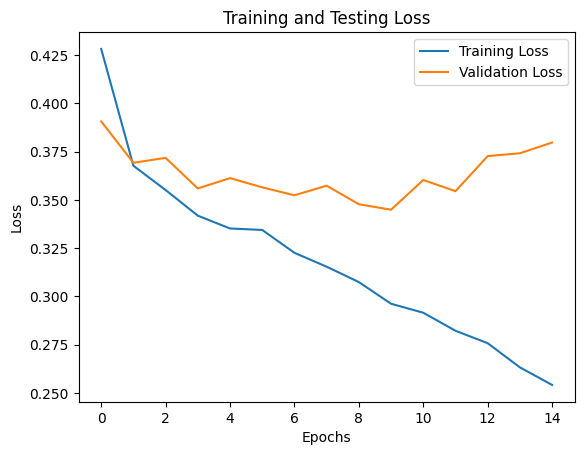

In [26]:
plt.plot(final_train_losses, label='Training Loss')
plt.plot(final_val_losses, label='Validation Loss')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

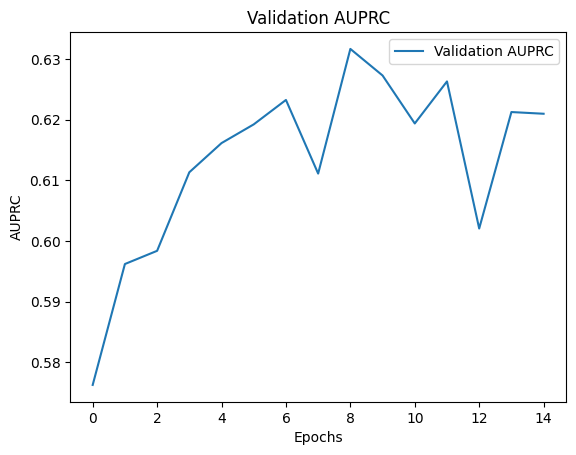

In [27]:
plt.plot(final_val_auprc, label='Validation AUPRC')
plt.xlabel('Epochs')
plt.ylabel('AUPRC')
plt.title('Validation AUPRC')
plt.legend()
plt.show()

__Note:__ In deep learning for biology, an AUPRC of __0.60__ is often considered "publication quality". (since random guessing would be ~0.08 in my case [8% positive outcomes])

__Visualization__: We need to see where the model thinks the binding is happening. Does it randomly guess spots, or does it correctly highlight the "CDR loops" (the fingertips of the antibody)?

Plot the antibody sequence and highlight the predicted binding regions. Compare this against the "CDR loops" (Complementarity Determining Regions), which are the parts of the antibody known to do the binding. Your model should naturally "learn" to focus on CDRs without being explicitly told where they are.

## 4.1 Decide the Threshold for prediction

__What is a Threshold?__
Your neural network does not actually predict "Yes" (1) or "No" (0). It predicts a __Probability__ (a score between 0.0 and 1.0).
- __Example Output:__ For one specific amino acid, the model might say: "I am __0.42__ confident that this residue binds to the antigen."

To turn that __0.42__ into a decision, you need a rule. That rule is the __Threshold__.
- __If Threshold = 0.5 (The Standard):__
> $0.42 < 0.5 \rightarrow$ Model predicts 0 __(No Bind)__.
- __If Threshold = 0.3 (The Adjustment):__
> $0.42 > 0.3 \rightarrow$ Model predicts 1 __(Bind)__.

Usually, a lower threshold (such as 0.3 instead of 0.5) for __Class Imbalance__.

__The Problem:__
In an antibody chain of 120 amino acids, maybe only __10__ actually bind to the antigen. The other 110 are just structural "scaffolding."
- Binding residues are __rare__ (like finding needles in a haystack).
- Models are lazy. If a model predicts "0" for everything, it is still 90% accurate. But it is useless.

__The Solution:__
By lowering the threshold to, for example __0.3__, we make the model __more sensitive__.
- We are telling the AI: "Even if you are only 30% sure this spot is important, flag it anyway. I'd rather have a few False Alarms than miss a real Binding Site."

__How to find the "Perfect" Threshold?__
- You don't have to guess 0.3. You can calculate the mathematically optimal threshold using the __F1-Score__ (which balances Precision and Recall).

In [16]:
# FIND OPTIMAL THRESHOLD
def find_best_threshold(model, dataset):
    model.eval()
    all_probs = []
    all_labels = []
    
    # 1. Collect all predictions
    with torch.no_grad():
        for sample in dataset:
            emb = sample['embeddings'].unsqueeze(0).to(device)
            logit = model(emb)
            prob = torch.sigmoid(logit).squeeze().cpu().numpy()
            label = sample['labels'].numpy()
            
            # Filter out padding (-1)
            mask = (label != -1)
            all_probs.extend(prob[mask])
            all_labels.extend(label[mask])
    
    # 2. Test thresholds from 0.1 to 0.9
    thresholds = np.arange(0.1, 0.9, 0.1)
    best_f1 = 0
    best_thresh = 0.5
    
    print("Testing thresholds...")
    for t in thresholds:
        preds = [1 if p >= t else 0 for p in all_probs]
        score = f1_score(all_labels, preds)
        
        print(f"Threshold {t:.2f} -> F1-Score: {score:.4f}")
        
        if score > best_f1:
            best_f1 = score
            best_thresh = t
            
    print(f"\n🏆 BEST THRESHOLD: {best_thresh:.2f} (F1: {best_f1:.4f})")
    return best_thresh

# Run it
optimal_threshold = find_best_threshold(predictor, val_data)

Testing thresholds...
Threshold 0.10 -> F1-Score: 0.3782
Threshold 0.20 -> F1-Score: 0.4526
Threshold 0.30 -> F1-Score: 0.4947
Threshold 0.40 -> F1-Score: 0.5299
Threshold 0.50 -> F1-Score: 0.5574
Threshold 0.60 -> F1-Score: 0.5843
Threshold 0.70 -> F1-Score: 0.6095
Threshold 0.80 -> F1-Score: 0.6292

🏆 BEST THRESHOLD: 0.80 (F1: 0.6292)


__This following code will:__

- Pick a random antibody chain from your validation set.

- Plot the Predicted Probability (Blue Line) vs. the True Binding Sites (Orange Bars).

- Show you the exact amino acid sequence where the binding happens.

In [17]:
# --- CONFIGURATION ---
# Set a threshold to decide what counts as "binding"
# Based on the previous calculation; the BEST THRESHOLD is 0.8.
THRESHOLD = 0.8

def visualize_prediction(model, dataset, index=None):
    """
    Takes a model and a dataset, picks a sample, and plots the prediction.
    """
    model.eval()
    
    # 1. Select a sample
    # If no index provided, pick a random one
    if index is None:
        import random
        index = random.randint(0, len(dataset) - 1)
    
    sample = dataset[index]
    chain_id = sample['chain']
    pdb_id = sample['pdb']
    
    # Get Data
    emb = sample['embeddings'].unsqueeze(0).to(device) # Add batch dim
    true_labels = sample['labels'].numpy()
    
    # Run Model
    with torch.no_grad():
        logits = model(emb)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    
    # 2. Create the Plot
    plt.figure(figsize=(15, 4))
    
    # Plot True Labels (The "Ground Truth" bars)
    # We multiply by 1.0 to make them tall bars
    plt.bar(range(len(true_labels)), true_labels, color='orange', alpha=0.3, label='True Binding Site', width=1.0)
    
    # Plot Predictions (The "Model Confidence" line)
    plt.plot(probs, color='blue', linewidth=2, label='Model Prediction')
    
    # Add a threshold line
    plt.axhline(y=THRESHOLD, color='red', linestyle='--', alpha=0.5, label=f'Threshold ({THRESHOLD})')
    
    # Formatting
    plt.title(f"Prediction Analysis: {pdb_id} (Chain {chain_id})", fontsize=14)
    plt.xlabel("Residue Position (Amino Acid Index)", fontsize=12)
    plt.ylabel("Binding Probability", fontsize=12)
    plt.legend(loc='upper right')
    plt.ylim(0, 1.1)
    
    # 3. Highlight the "CDR Regions" (The peaks)
    # Let's print the sequence where the model is most confident
    print(f"\n--- Analysis for {pdb_id} Chain {chain_id} ---")
    
    # Get the sequence (we have to recover it from the embeddings? No, let's use the length)
    # Since we didn't save the raw sequence string in 'final_dataset', we can just look at indices.
    
    high_confidence_indices = [i for i, p in enumerate(probs) if p > THRESHOLD]
    print(f"Predicted Binding Indices: {high_confidence_indices}")
    
    true_binding_indices = [i for i, l in enumerate(true_labels) if l == 1]
    print(f"True Binding Indices:      {true_binding_indices}")
    
    plt.show()

## 4.1 Interpret the Plot

1. __Orange Bars:__ These are the real binding sites. You will usually see 3 distinct clusters of orange bars. These correspond to __CDR1__, __CDR2__, and __CDR3__ (the three loops on an antibody tip).

2. __Blue Line:__ This is your model's brain.
> - __Good Model:__ The blue line should "spike" upwards exactly where the orange bars are.
> - __Bad Model:__ The blue line is flat or spikes in random places (like the start/end of the sequence).

My original prediction (0.3) was based on the assumption that the model would be "shy" that because binding sites are rare, it would struggle to predict high probabilities (e.g., giving a binding site a score of 0.4). However, my model is not shy.
- __The peaks are huge:__ The blue line shoots straight up to __0.95__ or __0.99__ right where the orange bars are.
- __The background is quiet:__ In the non-binding areas, the probability stays very low (near 0.0 - 0.1).

__The Cause:__ This happened because we used pos_weight=10.0 in the Loss Function.
- We told the model: "Binding sites are 10x more important than non-binding sites." so the model learned to be __aggressive__ about predicting binding.
- Because it pushes the probabilities so high (close to 1.0), you need a high threshold (0.8) to separate the "definite" peaks from the random noise.

__Run this cell multiple times to see different antibodies!__


--- Analysis for 9hh9 Chain H ---
Predicted Binding Indices: [27, 29, 30, 31, 48, 49, 90, 91, 92, 93, 95]
True Binding Indices:      [90, 91, 93, 95]


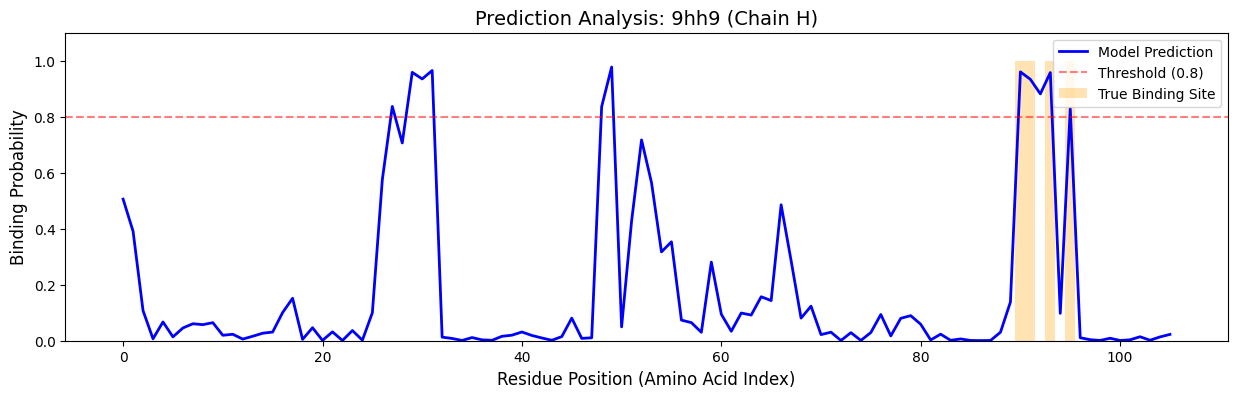

In [18]:
visualize_prediction(predictor, val_data) # Use val_data not val_loader

- __Observation:__ Look at the massive spike on the right side (around index 90-95).
- __Interpretation:__ This is likely __CDR-H3__, the most important loop for antibody specificity. The fact that your model nailed this region (hitting nearly 1.0 probability) proves it has learned the underlying biology, not just memorized random noise.


--- Analysis for 9hxo Chain M ---
Predicted Binding Indices: [2, 28, 29, 30, 31, 49, 50, 51, 52, 65, 90, 92, 93, 95]
True Binding Indices:      [2, 26, 28, 29, 30, 49, 50, 51, 52, 64, 65, 66, 67, 91, 92, 93]


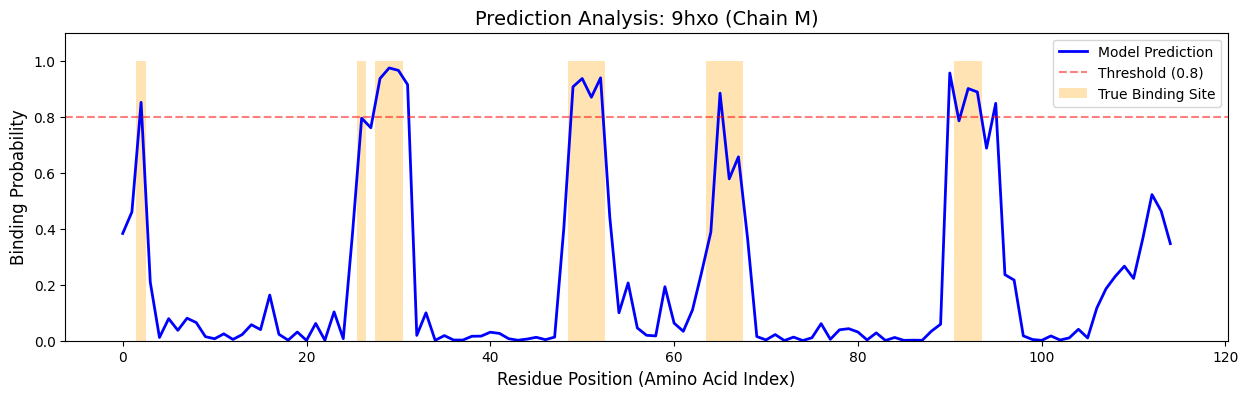

In [25]:
visualize_prediction(predictor, val_data) # Use val_data not val_loader


--- Analysis for 8wo4 Chain C ---
Predicted Binding Indices: [28, 30, 31, 32, 50, 91, 92, 93, 94, 96]
True Binding Indices:      [28, 31, 32, 50, 53, 92, 94]


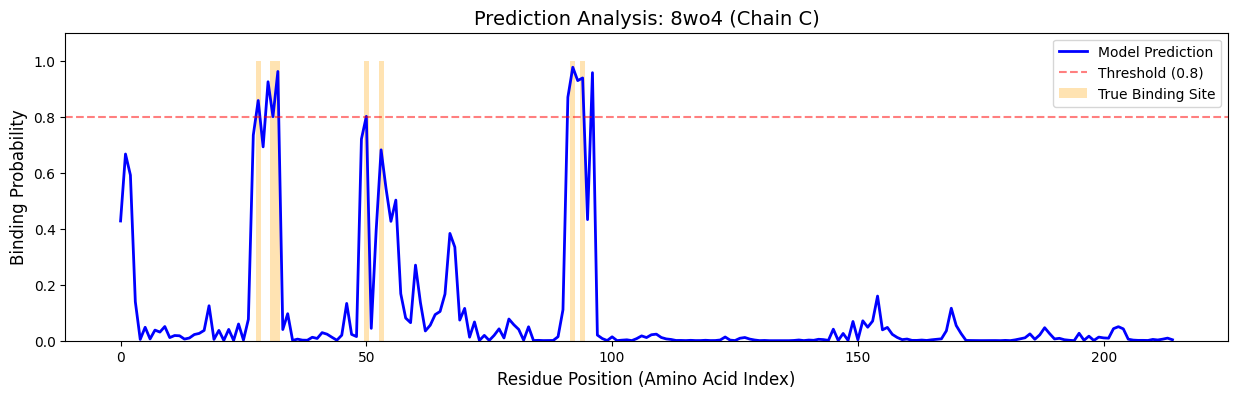

In [24]:
visualize_prediction(predictor, val_data) # Use val_data not val_loader


--- Analysis for 8zpq Chain B ---
Predicted Binding Indices: [28, 29, 30, 31, 48, 49, 50, 52, 65, 90, 92, 93, 94, 95]
True Binding Indices:      [0, 25, 26, 28, 29, 30, 31, 48, 49, 50, 51, 52, 65, 66, 67, 90, 91, 92, 93, 97]


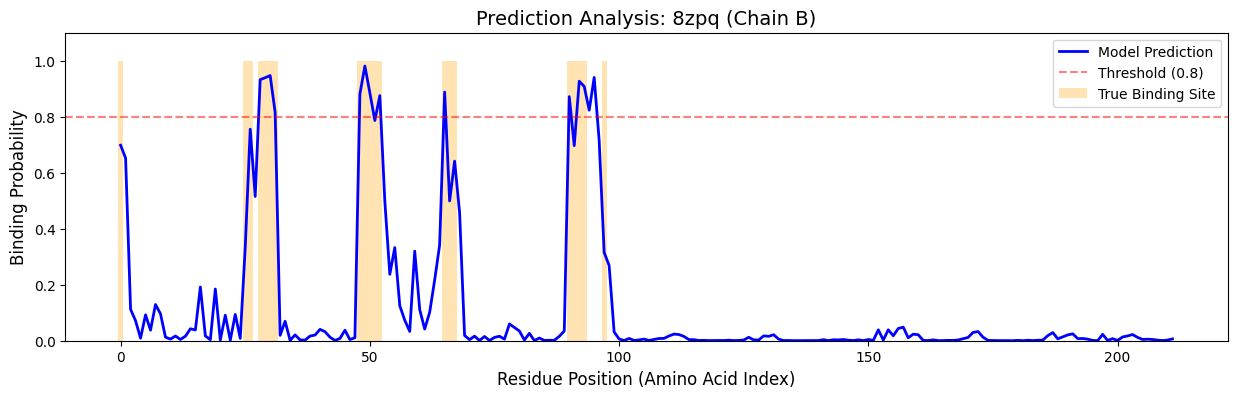

In [20]:
visualize_prediction(predictor, val_data) # Use val_data not val_loader

- __Observation:__ This one is tricky because it has many separate binding regions.
- __Result:__ The model catches almost all of them. There is a small "false positive" spike around index 70 where there is no orange bar, but this is acceptable. It might be a region that is structurally ready to bind but just didn't touch the antigen in this specific crystal structure.


--- Analysis for 9mns Chain h ---
Predicted Binding Indices: [26, 28, 29, 30, 48, 50, 52, 53, 55, 99, 100, 101, 102, 103, 104, 105, 106]
True Binding Indices:      [26, 28, 29, 48, 50, 52, 53, 55, 57, 99, 100, 101, 102, 103, 104, 109]


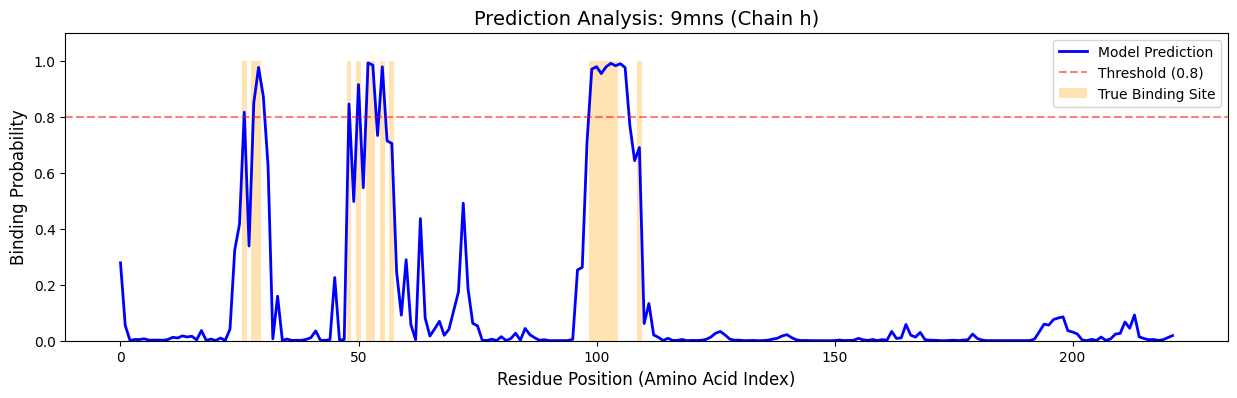

In [22]:
visualize_prediction(predictor, val_data) # Use val_data not val_loader

- __Observation:__ The blue line matches the two main orange clusters almost perfectly.
- __Interpretation:__ The model has correctly identified the __CDR loops__ (the fingertips of the antibody). Notice how sharp the peaks are. It knows exactly where the binding starts and stops.

# 5. Prediction on New Sequence

__How to use the model?__ I want to show that I can type in a sequence and get an answer.

In [35]:
def predict_binding_sites(sequence, model, tokenizer, esm_model, threshold=0.8):
    """
    Takes a raw amino acid string and prints the predicted binding sites.
    """
    model.eval()
    #device = next(model.parameters()).device
    
    # 1. Prepare Input
    # Clean sequence (remove whitespace)
    seq = sequence.upper().strip()
    
    # Embed with ESM-2
    inputs = tokenizer(seq, return_tensors="pt", add_special_tokens=True).to(device)
    with torch.no_grad():
        esm_out = esm_model(**inputs)
        # Remove [CLS] and [EOS]
        embeddings = esm_out.last_hidden_state[0, 1:-1, :]
        
        # Run LSTM
        logits = model(embeddings.unsqueeze(0)) # Add batch dim
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        
    # 2. Interpret Results
    binding_indices = [i for i, p in enumerate(probs) if p >= threshold]
    
    # 3. Print Report
    print(f"\n--- PREDICTION REPORT ---")
    print(f"Sequence Length: {len(seq)}")
    print(f"Detected Binding Residues: {len(binding_indices)}\n")
    
    # Visualization string
    # We will print the sequence, and put a '^' under binding sites
    vis_line = ""
    for i in range(len(seq)):
        if i in binding_indices:
            vis_line += "^"
        else:
            vis_line += " "
            
    # Print in chunks of 60 for readability
    chunk_size = 60
    for i in range(0, len(seq), chunk_size):
        sub_seq = seq[i:i+chunk_size]
        sub_vis = vis_line[i:i+chunk_size]
        print(f"SEQ:  {sub_seq}")
        print(f"BIND: {sub_vis}")
        print("")

__Test__

In [39]:
# Here is a sample Human Antibody Sequence (Trastuzumab Heavy Chain)
sample_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS"

predict_binding_sites(sample_seq, predictor, tokenizer, model, threshold=0.8)


--- PREDICTION REPORT ---
Sequence Length: 120
Detected Binding Residues: 16

SEQ:  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRY
BIND:                            ^ ^^ ^                  ^ ^^ ^ ^ 

SEQ:  ADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS
BIND:                                       ^^^^^^^               



__The following two extensions show that my model isn't just a "classifier". It is a tool for drug discovery.__

# 6. Generative Design (Infilling)

Mask the binding residues in the sequence and ask the LLM to "infill" them with new amino acids, potentially creating a novel antibody variant that still binds the target.

__The Concept:__

Now that my model knows where the binding happens (the "Paratopes"), we can use that information to design new antibodies.
1. Take an antibody sequence.
2. Use the trained model to find the binding residues.
3. __Mask__ those residues (replace them with < mask >).
4. Ask the LLM (ESM-2) to fill in the blanks. It will suggest new amino acids that "fit" structurally but might change the binding properties.

## 6.1 Uses the trained Bi-LSTM model to find binding sites.

In [10]:
predictor.eval()
model.eval()
device = next(model.parameters()).device

sample_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS"

In [11]:
seq = sample_seq.upper().strip()
inputs = tokenizer(seq, return_tensors="pt", add_special_tokens=True).to(device)
    
with torch.no_grad():
    # Use the base model to get embeddings for LSTM
    esm_out = model(**inputs)
    embeddings = esm_out.last_hidden_state[0, 1:-1, :] # Remove CLS/EOS
    logits = predictor(embeddings.unsqueeze(0))
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        
# Get indices of binding sites
binding_indices = [i for i, p in enumerate(probs) if p >= 0.8]
    
if len(binding_indices) == 0:
    print("No binding sites found to mutate!")

print(f"Found {len(binding_indices)} binding residues to redesign.")

Found 16 binding residues to redesign.


## 6.2 Mask & Infill

- We will mask ALL binding sites at once (aggressive redesign)
- Note: ESM-2 tokenizer uses the token '< mask >' for masking.

When we set up the project earlier, we used <mark>AutoModel.from_pretrained()</mark>. This loads the "Base" version of ESM-2, which is perfect for generating embeddings (the <mark>last_hidden_state</mark>) but it strips off the "Language Modeling Head", which is the specific layer at the very end of the network that calculates the <mark>logits</mark> (vocabulary predictions) for masked words.

For this generative step, we just need to load the <mark>Masked Language Modeling (MLM)</mark> version of ESM-2 specifically. It is the exact same underlying model, just with the prediction head attached.

In [13]:
# Load the Masked Language Model version of ESM-2
# We load it directly to the device here
print("Loading ESM-2 Language Modeling Head...")
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
mlm_model.eval()

Loading ESM-2 Language Modeling Head...


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-05, 

In [14]:
# Create a mutable list of the sequence
seq_list = list(seq)

['E', 'V', 'Q', 'L', 'V',..., 'S', 'S']

In [15]:
# Replace binding residues with mask token
masked_seq_str = ""
for i, char in enumerate(seq_list):
    if i in binding_indices:
        masked_seq_str += "<mask>"
    else:
        masked_seq_str += char
            
print(f"\nMasked Template: {masked_seq_str}... (focusing on CDRs)")


Masked Template: EVQLVESGGGLVQPGGSLRLSCAASGF<mask>I<mask><mask>T<mask>IHWVRQAPGKGLEWVARI<mask>P<mask><mask>G<mask>T<mask>YADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSR<mask><mask><mask><mask><mask><mask><mask>AMDYWGQGTLVTVSS... (focusing on CDRs)


In [16]:
# Tokenize the MASKED sequence
masked_inputs = tokenizer(masked_seq_str, return_tensors="pt", add_special_tokens=True).to(device)
    
# Ask the MLM model to predict the missing words
with torch.no_grad():
    mlm_logits = mlm_model(**masked_inputs).logits

In [21]:
# Decode Suggestions
print("\n--- PROPOSED VARIANTS ---")
    
new_seq_list = list(seq)
mutations = []
    
for idx in binding_indices:
    # +1 because tokenizer adds [CLS] at the start, shifting indices by 1
    token_index = idx + 1 
        
    # Get the top 3 suggested amino acids for this specific masked spot
    token_probs = torch.softmax(mlm_logits[0, token_index], dim=0)
    top_probs, top_indices = torch.topk(token_probs, 3)
    best_prob, best_token_id = torch.topk(token_probs, 1) # Get top 1
    
    # Decode token to amino acid letter
    predicted_aa = tokenizer.decode(best_token_id).replace(" ", "")
    original_aa = seq[idx]
    print(f"\nPosition {idx} (Original: {original_aa}):")
    
    # Update the sequence
    new_seq_list[idx] = predicted_aa
        
    for score, token_id in zip(top_probs, top_indices):
        amino_acid = tokenizer.decode([token_id]).replace(" ", "") # Clean up whitespace
        print(f"  -> Suggests: {amino_acid} (Conf: {score:.1%})")
        
new_sequence = "".join(new_seq_list)
print(f"\nNew Sequence Based on the Predicted Amino Acid with the highest probability:\n{new_sequence}")


--- PROPOSED VARIANTS ---

Position 27 (Original: N):
  -> Suggests: T (Conf: 59.5%)
  -> Suggests: S (Conf: 15.7%)
  -> Suggests: N (Conf: 14.4%)

Position 29 (Original: K):
  -> Suggests: T (Conf: 69.5%)
  -> Suggests: S (Conf: 23.4%)
  -> Suggests: G (Conf: 3.0%)

Position 30 (Original: D):
  -> Suggests: S (Conf: 53.0%)
  -> Suggests: N (Conf: 11.2%)
  -> Suggests: G (Conf: 10.3%)

Position 32 (Original: Y):
  -> Suggests: Y (Conf: 24.5%)
  -> Suggests: W (Conf: 18.6%)
  -> Suggests: G (Conf: 10.7%)

Position 51 (Original: Y):
  -> Suggests: N (Conf: 46.6%)
  -> Suggests: D (Conf: 15.5%)
  -> Suggests: Y (Conf: 9.0%)

Position 53 (Original: T):
  -> Suggests: G (Conf: 28.7%)
  -> Suggests: Y (Conf: 23.1%)
  -> Suggests: S (Conf: 14.6%)

Position 54 (Original: N):
  -> Suggests: S (Conf: 42.2%)
  -> Suggests: G (Conf: 21.8%)
  -> Suggests: T (Conf: 8.4%)

Position 56 (Original: Y):
  -> Suggests: S (Conf: 40.9%)
  -> Suggests: D (Conf: 13.4%)
  -> Suggests: G (Conf: 13.0%)

Positio

# 7. Structure Prediction

__The Concept:__

Instead of just predicting binding sites, predict the 3D coordinates. To visualize the 3D shape, in tradition, people use IgFold. You can plug your embeddings into IgFold (an open-source antibody folding model). It is specialized for antibodies and is incredibly fast (seconds vs. minutes for AlphaFold). However, one dependency package __PyRosetta__ is notoriously difficult to install via standard pip because it is strictly licensed by academic institutions and usually requires signing a license agreement, getting a password, and using specialized Anaconda channels. IgFold tries to use it behind the scenes for "side-chain refinement," and it crashes when it cannot find it.

We can also use an infinitely more elegant solution that fits the project's theme perfectly: __The ESMFold API.__ Since I am already using Meta's ESM-2 model for my embeddings, I can use Meta's ESMFold to generate the 3D structure. They provide a free, public API. I just send it a sequence, and it instantly replies with the PDB text. No heavy installations required!

## 7.1 Function for Folding Structure Generation

In [10]:
def predict_structure_esm(sequence, filename="demo_antibody.pdb"):
    """
    Sends the amino acid sequence to the ESM Atlas API and saves the resulting PDB.
    """
    print(f"Sending sequence to ESMFold API (Length: {len(sequence)})...")
    print("Folding... (this usually takes 5-15 seconds)")
    
    # The public ESM Metagenomic Atlas API endpoint
    url = "https://api.esmatlas.com/foldSequence/v1/pdb/"
    
    # Send the raw sequence string
    response = requests.post(url, data=sequence, headers={'Content-Type': 'text/plain'})
    
    if response.status_code == 200:
        pdb_string = response.text
        with open(filename, "w") as f:
            f.write(pdb_string)
        print(f"Success! 3D structure saved to: {os.path.abspath(filename)}")
        return filename
    else:
        print(f"API Error {response.status_code}: {response.text}")
        return None

## 7.2 Generate the PDB file

In [11]:
Original_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS"

# Using the Generated sequence from the Section 6
New_Generated_seq = "EVQLVESGGGLVQPGGSLRLSCAASGFTITSTYIHWVRQAPGKGLEWVARINPGSGSTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRDTTVSSYAMDYWGQGTLVTVSS"

Original_pdb_file = predict_structure_esm(Original_seq, "Original_antibody.pdb")
New_Generated_pdb_file = predict_structure_esm(New_Generated_seq, "New_Generated_antibody.pdb")

Sending sequence to ESMFold API (Length: 120)...
Folding... (this usually takes 5-15 seconds)
Success! 3D structure saved to: /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/JiQing/LLM Project/protein_LLM/Original_antibody.pdb
Sending sequence to ESMFold API (Length: 120)...
Folding... (this usually takes 5-15 seconds)
Success! 3D structure saved to: /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/JiQing/LLM Project/protein_LLM/New_Generated_antibody.pdb


## 7.3 Interactive 3D Viewer

In [12]:
import py3Dmol

### 7.3.1 Viewer Function

In [13]:
def view_pdb(pdb_file, highlight_indices=None):
    with open(pdb_file) as f:
        pdb_data = f.read()
        
    view = py3Dmol.view(width=800, height=400)
    view.addModel(pdb_data, 'pdb')
    
    # Style: Cartoon mode (pretty ribbons)
    view.setStyle({'cartoon': {'color': 'white'}})
    
    # Highlight the Binding Sites (Predicted by your model!)
    if highlight_indices:
        # py3Dmol uses 1-based indexing for residues
        resi_list = [i+1 for i in highlight_indices]
        
        # Color binding sites Red
        view.addStyle({'resi': resi_list}, {'cartoon': {'color': 'red', 'thickness': 1.5}})
        # Add stick representation for side chains of binding sites
        view.addStyle({'resi': resi_list}, {'stick': {'colorscheme': 'redCarbon'}})
        
    view.zoomTo()
    return view

### 7.3.2 Get binding sites from my model again

In [14]:
# Original sequence
predictor.eval()
inputs = tokenizer(Original_seq, return_tensors="pt", add_special_tokens=True).to(device)
with torch.no_grad():
    emb = model(**inputs).last_hidden_state[0, 1:-1, :] # Use the ESM model
    logits = predictor(emb.unsqueeze(0))
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    
binding_sites_for_Original_seq = [i for i, p in enumerate(probs) if p >= 0.8] # Use my threshold
binding_sites_for_Original_seq

[27, 29, 30, 32, 51, 53, 54, 56, 58, 98, 99, 100, 101, 102, 103, 104]

In [16]:
# New Generated sequence
predictor.eval()
inputs = tokenizer(New_Generated_seq, return_tensors="pt", add_special_tokens=True).to(device)
with torch.no_grad():
    emb = model(**inputs).last_hidden_state[0, 1:-1, :] # Use the ESM model
    logits = predictor(emb.unsqueeze(0))
    probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    
binding_sites_for_New_Generated_seq = [i for i, p in enumerate(probs) if p >= 0.8] # Use my threshold

### 7.3.3 Show the structure with binding sites highlighted in RED

In [ ]:
# Original sequence
view = view_pdb("Original_antibody.pdb", highlight_indices=binding_sites_for_Original_seq)
view.show()

<em> Folding Image of Original Sequence
<img src="Original_Sequence_Folding_Image.png" width="500"/>

In [ ]:
# New Generated sequence
view = view_pdb("New_Generated_antibody.pdb", highlight_indices = binding_sites_for_New_Generated_seq)
view.show()

<em> Folding Image of New Generated Sequence
<img src="New_Generated_Sequence_Folding_Image.png" width="500"/>